# IMD and OOMD Limits Analysis

Analyze Hotelling's T² (In-Model Distance) and DModX (Out-Of-Model Distance) with control limits.

> `ipykernel` and `matplotlib` are needed as additional dependencies to run this notebook.

## 1. Import Required Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Add the src directory to path to import open_nipals
from open_nipals.nipalsPCA import NipalsPCA

# Set random seed for reproducibility
seed = 1337
rng = np.random.default_rng(seed)

# Configure matplotlib
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 12

# Set up working directory for saving figures
work_dir = Path.cwd()

# saveflag
saveflag = True

## 2. Generate Sparse Test Dataset

In [4]:
# prepare data
samp = 1000
feat = 40
nan_pct = 0.1
decay_amp_base = 0.9
noise_amp = 0.1

# decaying components magnitude without loss of generality
amp = decay_amp_base ** np.arange(feat)

# construct random orthogonal base
decomp = rng.standard_normal((feat, feat))
loadings, _ = np.linalg.qr(decomp)

# random scores, without loss of generality
# in decaying order
scores = rng.standard_normal((samp, feat)) * amp

# construct data
x_data = scores @ loadings

# Add small noise
x_data += rng.standard_normal((samp, feat)) * noise_amp

# introduce some NaN values
nan_mask = rng.uniform(0, 1, (samp, feat)) < nan_pct
x_data[nan_mask] = np.nan

# unit scale
scaler = StandardScaler()
scaled_x_data = scaler.fit_transform(x_data)

## 3. IMD and OOMD Limits Analysis

Analyze Hotelling's T² (In-Model Distance) and DModX (Out-Of-Model Distance) for the maximal example dataset with 100 features and 4 components.

In [5]:
# number of model components
n_components = 4

# Fit NIPALS PCA model
pca_model = NipalsPCA(n_components=n_components).fit(scaled_x_data)

# Calculate In-Model Distance (IMD) - Hotelling's T²
imd = pca_model.calc_imd(
    input_scores=pca_model.fit_scores, metric="HotellingT2"
)

# Calculate Out-Of-Model Distance (OOMD) - DModX
oomd = pca_model.calc_oomd(scaled_x_data, metric="DModX")

# Calculate control limits
imd_limit = pca_model.calc_limit(metric="HotellingT2", alpha=0.95)
oomd_limit = pca_model.calc_limit(metric="DModX", alpha=0.95)

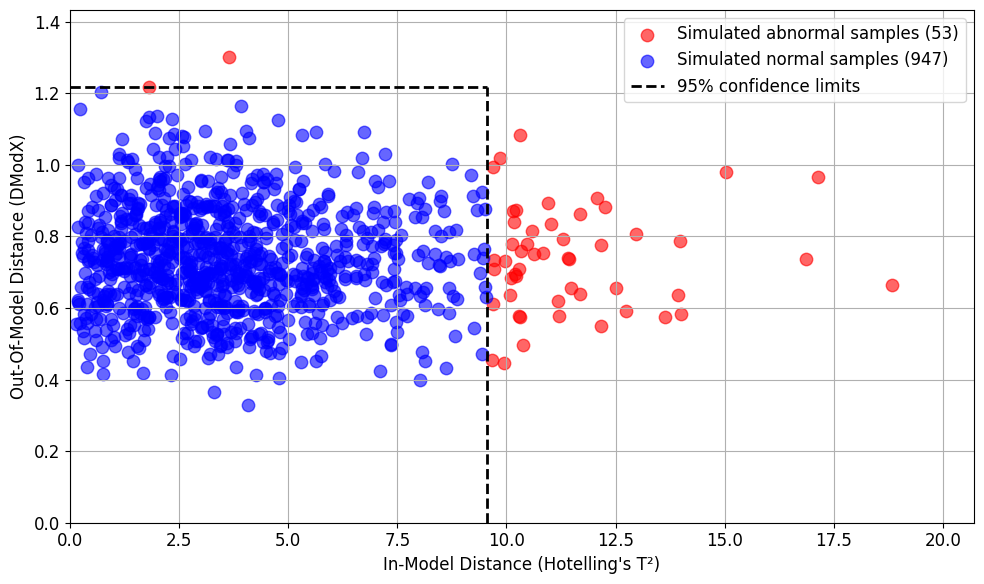

In [6]:
# Create scatter plot with IMD on x-axis and OOMD on y-axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Determine colors based on whether samples exceed either limit
log_vec = ((imd > imd_limit) | (oomd > oomd_limit)).reshape(-1)
ax.scatter(
    imd[log_vec],
    oomd[log_vec],
    alpha=0.6,
    c="red",
    s=80,
    label=f"Simulated abnormal samples ({np.sum(log_vec)})",
)
ax.scatter(
    imd[~log_vec],
    oomd[~log_vec],
    alpha=0.6,
    c="blue",
    s=80,
    label=f"Simulated normal samples ({np.sum(~log_vec)})",
)

# Plot control limits as dashed lines
ax.vlines(
    x=imd_limit,
    ymin=0,
    ymax=oomd_limit,
    colors="black",
    linestyles="dashed",
    linewidth=2,
    label="95% confidence limits",
)
ax.hlines(
    y=oomd_limit,
    xmin=0,
    xmax=imd_limit,
    colors="black",
    linestyles="dashed",
    linewidth=2,
)

# Set axis limits to start at 0
ax.set_xlim(0, max(np.max(imd), imd_limit) * 1.1)
ax.set_ylim(0, max(np.max(oomd), oomd_limit) * 1.1)

# Labels and title
ax.set_xlabel("In-Model Distance (Hotelling's T²)")
ax.set_ylabel("Out-Of-Model Distance (DModX)")

ax.grid(True)
ax.legend(loc="upper right")


plt.tight_layout()
if saveflag:
    plt.savefig(
        work_dir.joinpath("..", "plots", "HT2_DModX_example_plot.png"),
        dpi=900,
        bbox_inches="tight",
    )
plt.show()